In [1]:
EPOCHS = 100
IMG_SIZE = 224
BATCH_SIZE = 32

In [2]:
import numpy as np 
import pandas as pd 
import os
import tensorflow as tf
import shutil
from shutil import copyfile
from tqdm import tqdm

import matplotlib.pyplot as plt

from sklearn.metrics import classification_report,ConfusionMatrixDisplay, confusion_matrix

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import EfficientNetB0

2025-05-31 13:09:48.975480: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-31 13:09:48.975538: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-31 13:09:48.977247: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Preprocessing the HAM10000 dataset


In [3]:
df=pd.read_csv(r'/kaggle/input/ham1000-segmentation-and-classification/GroundTruth.csv')
print (df.head())
print (len(df))
print (df.columns)

 
label_names = ['MAL', 'BNN']

label_names = sorted(label_names)
# print(label_names)

df['image']=df['image'].apply(lambda x: x+ '.jpg')
# print (df.head())

          image  MEL   NV  BCC  AKIEC  BKL   DF  VASC
0  ISIC_0024306  0.0  1.0  0.0    0.0  0.0  0.0   0.0
1  ISIC_0024307  0.0  1.0  0.0    0.0  0.0  0.0   0.0
2  ISIC_0024308  0.0  1.0  0.0    0.0  0.0  0.0   0.0
3  ISIC_0024309  0.0  1.0  0.0    0.0  0.0  0.0   0.0
4  ISIC_0024310  1.0  0.0  0.0    0.0  0.0  0.0   0.0
10015
Index(['image', 'MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC'], dtype='object')


Here we create the empty directories corresponding to each class label.  In case we run this notebook or function a few times, we'll delete the directory structure (and all files in it recursively) if it already exists.

In [4]:
# Define root directory
data_dir = '/kaggle/working/lesions'

# Empty directory to prevent FileExistsError if the function is run several times
if os.path.exists(data_dir):
  shutil.rmtree(data_dir)

# Create the empty dir for each skin lesion
for label in label_names:
    os.makedirs(os.path.join(data_dir, label)) # e.g. /kaggle/working/lesions/MEL

In [5]:
# Iterate over dataframe and move images to correct folders
for index, row in tqdm(df.iterrows(), total=df.shape[0], desc=f'Copying HAM10000 dataset images..'):
    # Get the image pathname
    hot_label = row[row == 1].index.tolist()[0]
    image_name = row['image']
    a = ['MEL', 'BCC', 'AKIEC', 'VASC']
    if hot_label == 'NV':
        pass
    elif hot_label in a:
        hot_label = 'MAL'
        src_path = os.path.join("/kaggle/input/ham1000-segmentation-and-classification/images", image_name)
        dst_path = os.path.join(data_dir, hot_label, image_name)
        copyfile(src_path, dst_path)
    else:
        hot_label = 'BNN'
        src_path = os.path.join("/kaggle/input/ham1000-segmentation-and-classification/images", image_name)
        dst_path = os.path.join(data_dir, hot_label, image_name)
        copyfile(src_path, dst_path)

Copying HAM10000 dataset images..: 100%|██████████| 10015/10015 [00:33<00:00, 297.13it/s]


In [6]:
tot = 0
for label in label_names:
    cnt_label = len(os.listdir(os.path.join(data_dir, label)))
    print(f"There are {cnt_label} images with label {label}.")
    tot += cnt_label
print(f"\nThere are {tot} total images across all labels.")

There are 1214 images with label BNN.
There are 2096 images with label MAL.

There are 3310 total images across all labels.


# Preprocessing the ISIC 2019 dataset

In [7]:
df_isic=pd.read_csv(r'/kaggle/input/isic-2019/ISIC_2019_Training_GroundTruth.csv')
print (df_isic.columns)
# Add .jpg extension to the image filenames
df_isic['image']=df_isic['image'].apply(lambda x: x+ '.jpg')
x = df_isic.head()
print (df_isic.columns[1:])
# label_names = 

Index(['image', 'MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC', 'UNK'], dtype='object')
Index(['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC', 'UNK'], dtype='object')


In [8]:
# Iterate over dataframe and move images to correct folders
for index, row in tqdm(df_isic.iterrows(), total=df_isic.shape[0], desc=f'Copying ISIC 2019 dataset images..'):
    # Get the image pathname
    hot_label = row[row == 1].index.tolist()[0]
    image_name = row['image']
    a = ['MEL', 'BCC', 'AKIEC', 'VASC','AK','SCC']
    if hot_label == 'NV' or hot_label == 'UNK':
        pass
    elif hot_label in a:
        hot_label = 'MAL'
        src_path = os.path.join("/kaggle/input/isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input", image_name)
        dst_path = os.path.join(data_dir, hot_label, image_name)
        copyfile(src_path, dst_path)
    else:
        hot_label = 'BNN'
        src_path = os.path.join("/kaggle/input/isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input", image_name)
        dst_path = os.path.join(data_dir, hot_label, image_name)
        copyfile(src_path, dst_path)

Copying ISIC 2019 dataset images..: 100%|██████████| 25331/25331 [02:45<00:00, 153.07it/s]


In [9]:
tot = 0
for label in label_names:
    cnt_label = len(os.listdir(os.path.join(data_dir, label)))
    print(f"There are {cnt_label} images with label {label}.")
    tot += cnt_label
print(f"\nThere are {tot} total images across all labels.")

There are 2863 images with label BNN.
There are 9593 images with label MAL.

There are 12456 total images across all labels.


# Preprocessing the Melanoma-Cancer dataset

In [10]:
# Not using Benign images from this dataset due to the chance of making the final model biased
# Iterate over the new dataset and copy only the Benign images
benign_paths = [
                "/kaggle/input/melanoma-cancer-dataset/test/Benign",
                "/kaggle/input/melanoma-cancer-dataset/train/Benign"
                ]

for directory_path in benign_paths:

    files_and_directories = os.listdir(directory_path)


    only_files = [f for f in files_and_directories if os.path.isfile(os.path.join(directory_path, f))]
    for image_name in tqdm(only_files, desc=f'Copying Melanoma-Cancer dataset benign images..'):

        # Copy the image to the right label directory
        src_path = os.path.join(directory_path, image_name)
        dst_path = os.path.join(data_dir, 'BNN', image_name)
        copyfile(src_path, dst_path)

Copying Melanoma-Cancer dataset benign images..: 100%|██████████| 6289/6289 [00:39<00:00, 157.75it/s]


In [11]:
# Iterate over the new dataset and copy only the Malignant Images images
malignant_paths = [
                  "/kaggle/input/melanoma-cancer-dataset/test/Malignant",
                  "/kaggle/input/melanoma-cancer-dataset/train/Malignant"
                   ]

for directory_path in malignant_paths:

    files_and_directories = os.listdir(directory_path)


    only_files = [f for f in files_and_directories if os.path.isfile(os.path.join(directory_path, f))]
    for image_name in tqdm(only_files, desc=f'Copying Melanoma-Cancer dataset Malignant images..'):

        # Copy the image to the right label directory
        src_path = os.path.join(directory_path, image_name)
        dst_path = os.path.join(data_dir, 'MAL', image_name)
        copyfile(src_path, dst_path)

Copying Melanoma-Cancer dataset Malignant images..: 100%|██████████| 1000/1000 [00:06<00:00, 162.34it/s]
Copying Melanoma-Cancer dataset Malignant images..: 100%|██████████| 5590/5590 [00:35<00:00, 157.93it/s]


In [12]:
tot = 0
for label in label_names:
    cnt_label = len(os.listdir(os.path.join(data_dir, label)))
    print(f"There are {cnt_label} images with label {label}.")
    tot += cnt_label
print(f"\nThere are {tot} total images across all labels.")

There are 10152 images with label BNN.
There are 16183 images with label MAL.

There are 26335 total images across all labels.


In [13]:
def make_dataframe(sdir):
    
    filepaths=[]
    labels=[]
    classlist=sorted(os.listdir(sdir) )     
    for klass in classlist:
        classpath=os.path.join(sdir, klass) 
        if os.path.isdir(classpath):
            flist=sorted(os.listdir(classpath)) 
            desc=f'{klass:25s}'
            for f in tqdm(flist, ncols=130,desc=desc, unit='files', colour='blue'):
                fpath=os.path.join(classpath,f)
                filepaths.append(fpath)
                labels.append(klass)
    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')
    df=pd.concat([Fseries, Lseries], axis=1) 
    
    return df

def make_and_store_images(df, augdir, n,  img_size,  color_mode='rgb', save_prefix='aug-',save_format='jpg'):
    df=df.copy()        
    if os.path.isdir(augdir):# start with an empty directory
        shutil.rmtree(augdir)
    os.mkdir(augdir)  # if directory does not exist create it      
    for label in df['labels'].unique():    
        classpath=os.path.join(augdir,label)    
        os.mkdir(classpath) 
    total=0
     
    gen=ImageDataGenerator(horizontal_flip=True,  rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2)
    groups=df.groupby('labels')
    for label in df['labels'].unique():  
        classdir=os.path.join(augdir, label)
        group=groups.get_group(label)  # a dataframe holding only rows with the specified label 
        sample_count=len(group)   # determine how many samples there are in this class  
        if sample_count< n: # if the class has less than target number of images
            aug_img_count=0
            delta=n - sample_count  # number of augmented images to create            
            msg='{0:40s} for class {1:^30s} creating {2:^5s} augmented images'.format(' ', label, str(delta))
            print(msg, '\r', end='') # prints over on the same line
            aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=img_size,class_mode=None, batch_size=1, shuffle=False, 
                                            save_to_dir=classdir, save_prefix=save_prefix, color_mode=color_mode,save_format=save_format)
            while aug_img_count<delta:
                images=next(aug_gen)            
                aug_img_count += len(images)
            total +=aug_img_count        
    print('Total Augmented images created= ', total)
    
    
sdir=data_dir
df=make_dataframe(sdir)
print (df.head())
print ('length of dataframe is ',len(df))

augdir="/kaggle/working/aug" 
n=16000 
img_size=(IMG_SIZE,IMG_SIZE) 
make_and_store_images(df, augdir, n,  img_size,  color_mode='rgb', save_prefix='aug-',save_format='jpg')

MAL                      : 100%|█████████████████████████████████████████████████████| 16183/16183 [00:00<00:00, 809401.64files/s]

                              filepaths labels
0     /kaggle/working/lesions/BNN/1.jpg    BNN
1    /kaggle/working/lesions/BNN/10.jpg    BNN
2   /kaggle/working/lesions/BNN/100.jpg    BNN
3  /kaggle/working/lesions/BNN/1000.jpg    BNN
4  /kaggle/working/lesions/BNN/1001.jpg    BNN
length of dataframe is  26335
Found 10152 validated image filenames.   for class              BNN               creating 5848  augmented images 


Total Augmented images created=  5848


In [14]:
aug_path = "/kaggle/working/aug/BNN"
files_and_directories = os.listdir(aug_path)
only_files = [f for f in files_and_directories if os.path.isfile(os.path.join(aug_path, f))]
for image_name in tqdm(only_files, desc=f'Copying Augmented BNN images..'):
    src_path = os.path.join(aug_path, image_name)
    dst_path = os.path.join(data_dir, 'BNN', image_name)
    copyfile(src_path, dst_path)
    
aug_path = "/kaggle/working/aug/MAL"
files_and_directories = os.listdir(aug_path)
only_files = [f for f in files_and_directories if os.path.isfile(os.path.join(aug_path, f))]
for image_name in tqdm(only_files, desc=f'Copying Augmented MAL images..'):
    src_path = os.path.join(aug_path, image_name)
    dst_path = os.path.join(data_dir, 'MAL', image_name)
    copyfile(src_path, dst_path)

Copying Augmented BNN images..: 100%|██████████| 5848/5848 [00:00<00:00, 12142.74it/s]
Copying Augmented MAL images..: 0it [00:00, ?it/s]


In [15]:
tot = 0
for label in label_names:
    cnt_label = len(os.listdir(os.path.join(data_dir, label)))
    print(f"There are {cnt_label} images with label {label}.")
    tot += cnt_label
print(f"\nThere are {tot} total images across all labels.")

There are 16000 images with label BNN.
There are 16183 images with label MAL.

There are 32183 total images across all labels.


# Calculating Class Weights


In [16]:
# Start weights at zero
num_classes = len(label_names)
weights = [0] * num_classes  # e.g. [0, 0, 0, .. 0]

tot = 0
for idx, label in enumerate(label_names):
    cnt_label = len(os.listdir(os.path.join(data_dir, label)))
    weights[idx] = cnt_label  # really a count right now
    tot += cnt_label

class_frequencies = weights
class_frequencies = [ w / tot for w in weights ]  # [0.018897364771151177, 0.0297041 ...

weights = [ 1.0 / cnt for cnt in weights ]
weights = [ tot * w / num_classes for w in weights ]

class_weight = {}
for i in range(num_classes):
    class_weight[i] = weights[i]
    print(f"Weight for class {i}: " + '{:.2f}'.format(weights[i]))

Weight for class 0: 1.01
Weight for class 1: 0.99


In [17]:
# Now that images are in correct disk folder structure, we can create a tf data dataset easily. Can return the Train and val/test datasets all at once.
train_ds, val_and_test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=label_names,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True,
    seed=7,
    validation_split=0.2,  # Set aside 20% for val & test
    subset="both",
    crop_to_aspect_ratio=True,
)

Found 32183 files belonging to 2 classes.
Using 25747 files for training.
Using 6436 files for validation.


And then further split the val_test dataset in half to result in 10% splits each.

In [18]:
val_and_test_ds_size = len(list(val_and_test_ds))

val_size = int(val_and_test_ds_size * 0.5)
test_size = val_and_test_ds_size - val_size

val_ds = val_and_test_ds.take(val_size)
test_ds = val_and_test_ds.skip(val_size)

In [19]:
for images_batch, labels_batch in test_ds.take(1):
    print(images_batch.shape)
    print(labels_batch.shape)

(32, 224, 224, 3)
(32, 2)


# Visualize the Data

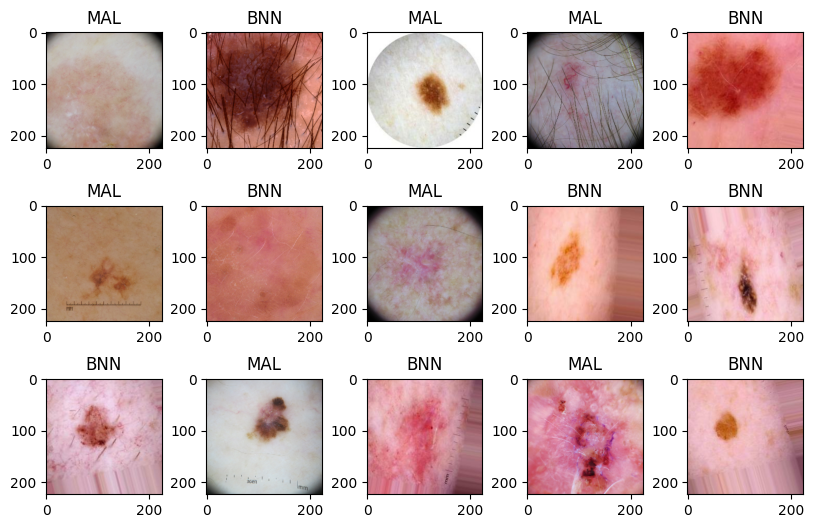

In [20]:
import matplotlib.pyplot as plt

n_rows = 3
n_cols = 5

plt.figure(figsize=(n_cols * 2.0, n_rows * 2.0))

# Get a batch to work with
for images_batch, labels_batch in train_ds.take(1):
    pass

for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)

        # Grab one image and convert it to NumPy type values
        img = images_batch[index, :, :, :].numpy()
        plt.imshow(img) #, cmap="binary", interpolation="nearest")

        # For the labels, we need to turn a length-8 one-hot EagerTensor
        # into the string label
        label_row = labels_batch[index, :]

        # Find the class label number with argmax and convert to NumPy type
        class_label = tf.argmax(label_row).numpy()

        # Look up the list
        class_label = label_names[class_label]

        # Use it on the plot
        plt.title(class_label)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

# Image Augmentation

This will allow us to train longer and give some regularizing effects.

In [21]:
image_augmentation = tf.keras.models.Sequential([
    tf.keras.layers.RandomRotation(factor=0.15),
    tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    tf.keras.layers.RandomFlip(mode="horizontal_and_vertical", seed=7),
])

In [22]:
# Cache dataset for performance and prefetch so CPU can do work while GPU training on current batch.  Train is already shuffled earlier.
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# The EfficientNet Model

# Step 1: Train just the Classifier

We'll first take off the old head from the model (with `include_top=False`) and replace it with our own classifier for our specific data.  First we'll freeze all the model weights and only train our classifier head.

In [23]:
METRICS = [
    tf.keras.metrics.BinaryCrossentropy(name='binary_crossentropy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.F1Score(name='f1'),
    tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
]


In [25]:
def build_model_EfficientNetB0(num_classes, metrics=METRICS, output_bias=None):

    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)

    # Inputs and augmentation
    inputs = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    aug_inputs = image_augmentation(inputs)

    # Base model
    model = EfficientNetB0(include_top=False, input_tensor=aug_inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top like in original paper
    x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2, name="top_dropout")(x)
    outputs = tf.keras.layers.Dense(num_classes,
                                    activation="sigmoid",
                                    # bias otherwise defaults to zeros
                                    bias_initializer=output_bias,
                                    name="pred")(x)

    # Compile Model
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")

    # Using a large learning rate for this part since most weights are fixed
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)

    model.compile(
        optimizer=optimizer, loss="binary_crossentropy", metrics=metrics,
    )

    return model

In [26]:
model_1 = build_model_EfficientNetB0(num_classes)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [27]:
models = [model_1]
# model.summary(show_trainable=True)
print("The following models are being trained - ")
for x in models:
    print(f"{x.name}")

The following models are being trained - 
EfficientNet


## Bias Initialization

Let's look at the loss *before* we start training and see if we've correctly initialized our bias in the final output stage.  See [this link](https://karpathy.github.io/2019/04/25/recipe/#2-set-up-the-end-to-end-trainingevaluation-skeleton--get-dumb-baselines) for more details (scroll down to *Init Well* section).

## Callbacks

We'll use Early Stopping to stop the model if the validation loss stops improving.
We'll also reduce the learning rate when learning starts to plateau.

In [28]:
# Use early stopping to train as long as possible
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
)

# And Reduce LR on Plateau to lower learning rate if stagnating
reduce_lr_on_plateau_cb = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,         # reduce by half (divide by 2)
    patience=5,         # must be lower than patience of early stopping
)

In [29]:
def plot_history(model,history):
    
    # Plot the loss and accuracy curves for training and validation
#     plt.title(model.name)
    fig, ax = plt.subplots(2,1)
    ax[0].set_title(f"{model.name} Loss")
    ax[0].plot(history.history['loss'], color='b', label="Training loss")
    ax[0].plot(history.history['val_loss'], color='r', label="validation loss")
    legend = ax[0].legend(loc='best', shadow=True)

    ax[1].set_title(f"\n{model.name} Accuracy")
    ax[1].plot(history.history['categorical_accuracy'], color='b', label="Training accuracy")
    ax[1].plot(history.history['val_categorical_accuracy'], color='r',label="Validation accuracy")
    legend = ax[1].legend(loc='best', shadow=True)
    fig.tight_layout()
    
def pred_confusion(model):
   
    true_labels = []
    for _, tmp_labels in test_ds:
        true_labels.append(tmp_labels.numpy())

    true_labels = np.concatenate(true_labels)
    true_labels = np.argmax(true_labels, axis=1)  # (1732,)

    print("Evaluating on test data")
    results = model.evaluate(test_ds, batch_size=BATCH_SIZE)
    
    print("Generating prediction data")

    test_predictions_baseline = model.predict(test_ds, batch_size=BATCH_SIZE)
    predicted_classes = np.argmax(test_predictions_baseline, axis=1)
    print(classification_report(true_labels, predicted_classes, target_names=label_names))


    cm = confusion_matrix(true_labels, predicted_classes)
    cm_display = ConfusionMatrixDisplay(cm,display_labels =label_names).plot()

## Train Classifier!

In [30]:
history = []
for i in models:
    print(f"Training model {i.name} - ")
    x = i.fit(train_ds,
                    epochs=EPOCHS,
                    validation_data=val_ds,
                    class_weight=class_weight,  # use our class weights here
                    callbacks=[early_stopping_cb, reduce_lr_on_plateau_cb],
                    verbose = 2
                   )
    history.append(x)
    print(f"{i.name} Training Complete")

Training model EfficientNet - 
Epoch 1/100


2025-05-31 13:21:51.039492: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/EfficientNet_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


805/805 - 71s - 89ms/step - binary_crossentropy: 0.5715 - categorical_accuracy: 0.7803 - f1: 0.7803 - loss: 0.5717 - precision: 0.7792 - recall: 0.7773 - val_binary_crossentropy: 0.4642 - val_categorical_accuracy: 0.8249 - val_f1: 0.8245 - val_loss: 0.4642 - val_precision: 0.8246 - val_recall: 0.8233 - learning_rate: 0.0100
Epoch 2/100
805/805 - 42s - 52ms/step - binary_crossentropy: 0.4680 - categorical_accuracy: 0.7972 - f1: 0.7971 - loss: 0.4682 - precision: 0.7977 - recall: 0.7962 - val_binary_crossentropy: 0.3961 - val_categorical_accuracy: 0.8308 - val_f1: 0.8300 - val_loss: 0.3961 - val_precision: 0.8335 - val_recall: 0.8304 - learning_rate: 0.0100
Epoch 3/100
805/805 - 42s - 52ms/step - binary_crossentropy: 0.4379 - categorical_accuracy: 0.8056 - f1: 0.8055 - loss: 0.4380 - precision: 0.8062 - recall: 0.8049 - val_binary_crossentropy: 0.3646 - val_categorical_accuracy: 0.8403 - val_f1: 0.8398 - val_loss: 0.3646 - val_precision: 0.8411 - val_recall: 0.8400 - learning_rate: 0.010

For model EfficientNet - 
Evaluating on test data
101/101 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - binary_crossentropy: 0.3485 - categorical_accuracy: 0.8543 - f1: 0.8540 - loss: 0.3485 - precision: 0.8543 - recall: 0.8543
Generating prediction data
101/101 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step
              precision    recall  f1-score   support

         BNN       0.87      0.83      0.85      1630
         MAL       0.84      0.87      0.85      1574

    accuracy                           0.85      3204
   macro avg       0.85      0.85      0.85      3204
weighted avg       0.85      0.85      0.85      3204

Model Saved as EfficientNet_classifier_head.keras
__________


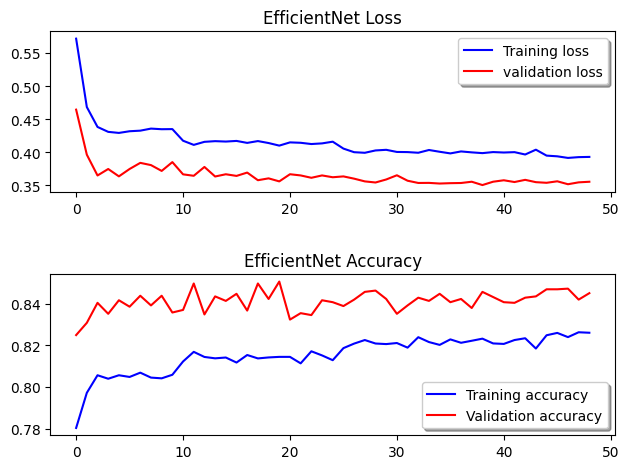

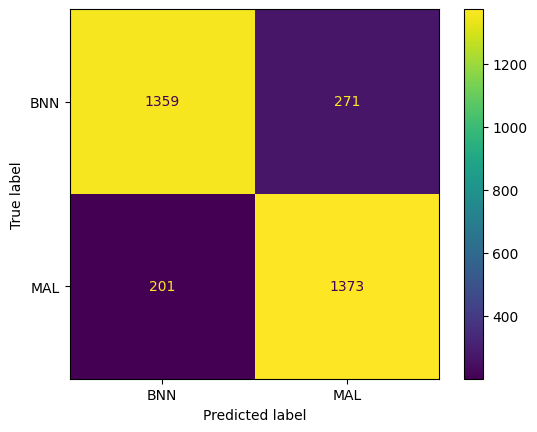

In [31]:
for i,j in zip(models,history):
    print(f"For model {i.name} - ")
    plot_history(i,j)
    pred_confusion(i)
    i.save(f'{i.name}_classifier_head.keras')
    print(f"Model Saved as {i.name}_classifier_head.keras")
    print("__________")


# Step 2. Unfreeze and Fine-Tune

Now that we've set up our classifier at the end using custom datasets (instead of the ImageNet dataset it was originally trained on), we can unfreeze all the weights and carefully fine-tune the entire model.  


In [32]:
def unfreeze_model(model, metrics=METRICS):

    for layer in model.layers:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True

    # Use a much smaller learning rate now to start
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

    # Recompile to 'freeze' which layers are frozen (not trainable)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=metrics
    )

for i in models:
    unfreeze_model(i)

## Fine-tune!

In [33]:
history = []
for i in models:
    print(f"Finetuning {i.name} model - ")
    x = i.fit(train_ds,
                    epochs=EPOCHS,
                    validation_data=val_ds,
                    class_weight=class_weight,  # use our class weights here
                    callbacks=[early_stopping_cb, reduce_lr_on_plateau_cb],
                    verbose = 2
                   )
    history.append(x)
    print(f"{i.name} Training Complete")

Finetuning EfficientNet model - 
Epoch 1/100


2025-05-31 14:02:04.323081: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/EfficientNet_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


805/805 - 182s - 227ms/step - binary_crossentropy: 0.3876 - categorical_accuracy: 0.8266 - f1: 0.8266 - loss: 0.4234 - precision: 0.8266 - recall: 0.8266 - val_binary_crossentropy: 0.3641 - val_categorical_accuracy: 0.8419 - val_f1: 0.8419 - val_loss: 0.3548 - val_precision: 0.8418 - val_recall: 0.8416 - learning_rate: 1.0000e-05
Epoch 2/100
805/805 - 159s - 198ms/step - binary_crossentropy: 0.3739 - categorical_accuracy: 0.8372 - f1: 0.8371 - loss: 0.3876 - precision: 0.8372 - recall: 0.8372 - val_binary_crossentropy: 0.3498 - val_categorical_accuracy: 0.8524 - val_f1: 0.8524 - val_loss: 0.3302 - val_precision: 0.8527 - val_recall: 0.8524 - learning_rate: 1.0000e-05
Epoch 3/100
805/805 - 159s - 198ms/step - binary_crossentropy: 0.3602 - categorical_accuracy: 0.8457 - f1: 0.8456 - loss: 0.3646 - precision: 0.8457 - recall: 0.8457 - val_binary_crossentropy: 0.3417 - val_categorical_accuracy: 0.8577 - val_f1: 0.8576 - val_loss: 0.3201 - val_precision: 0.8579 - val_recall: 0.8577 - learni

For model EfficientNet - 
Evaluating on test data
101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - binary_crossentropy: 0.2019 - categorical_accuracy: 0.9162 - f1: 0.9161 - loss: 0.1928 - precision: 0.9162 - recall: 0.9162
Generating prediction data
101/101 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step
              precision    recall  f1-score   support

         BNN       0.92      0.92      0.92      1630
         MAL       0.92      0.91      0.92      1574

    accuracy                           0.92      3204
   macro avg       0.92      0.92      0.92      3204
weighted avg       0.92      0.92      0.92      3204

Model Saved as EfficientNet_finetuned.keras
__________


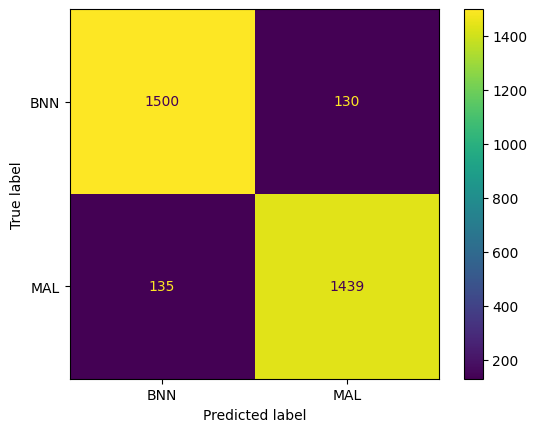

In [34]:
for i,j in zip(models,history):
    print(f"For model {i.name} - ")
#     plot_history(i,j)
    pred_confusion(i)
    i.save(f'{i.name}_finetuned.keras')
    print(f"Model Saved as {i.name}_finetuned.keras")
    print("__________")